# Bond Trading Analysis

## Indicator: Monetary Base (M2)
    

#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Claim: 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Growth in the monetary base over the past 3 months compared to the past 1 year is indicative of a higher propensity for increased inflation. The inflation &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; will erode returns of bonds and lead to raised interest rates. 

In [3]:
# If the below code doesn't work uncomment this and run (this adds the parent directory to the path)
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import numpy as np
from scipy.stats import norm

In [4]:
from pydatastream import Datastream
import matplotlib.pyplot as plt
from BasicSetupUtilities.MetaDataBuilder import CountryMetaDataFile
from DataIOUtilities.DataLib import DataLib, DatastreamPulls
import pandas as pd
import numpy as np
from datetime import date, timedelta

In [361]:
dl = DataLib("SignalData")
BondReturnIndex = dl.pull('BondRetIdx/LocalFX')
m2 = dl.pull("M2/inUSD")

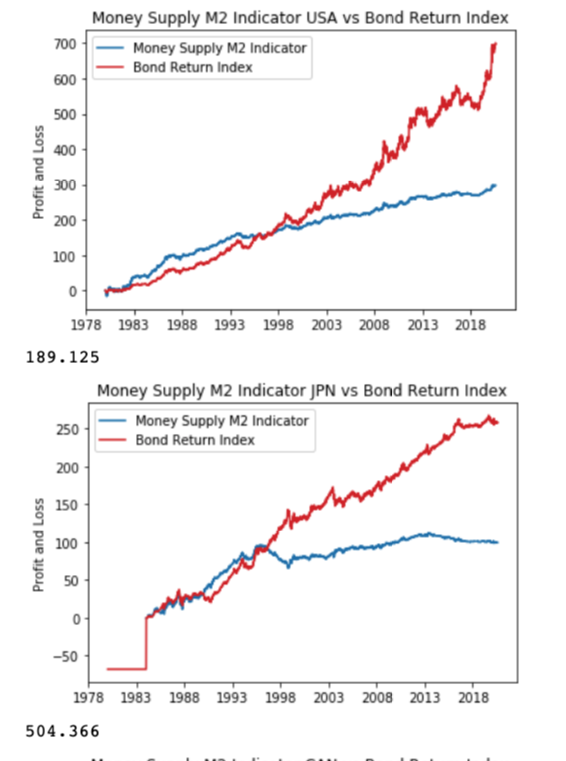

In [306]:
from IPython.display import Image
Image("image1.jpg",width = 600, height = 300)

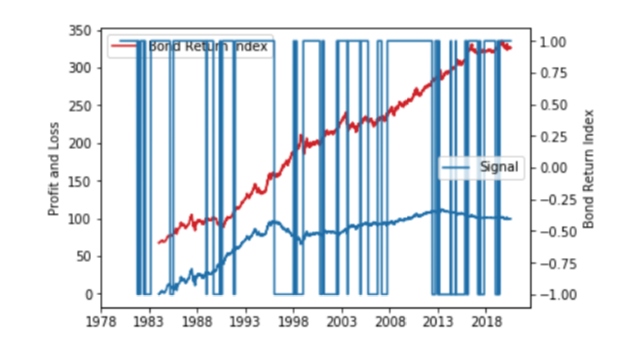

In [305]:
Image("image2.jpg",width = 600, height = 300)

2 issues: 1. it produces a completely binary signal, and 2. doesn't consider the time element

#### Stats

In [97]:
def standardize(value, count):
    return value[:count].std()

def z_score_calc(x, u, sd):
    
    return (x-u)/sd

#### Data manipulation + plotting functions

In [307]:
def plot_pnl(signals, indicator, country):
    pnl_values, table = pnl_series(signals, 100, country)
    
    table = table["return"]
    first_val = table.first_valid_index()
    table = table.fillna(0)
    table = table - table[first_val]
    #table = table.set_index("full-date")
    
    pnl_values = pnl_values.to_frame().set_index(pd.to_datetime(pnl_values.index))
    return pnl_values

def pnl_series(signals, bankroll, country, start=0, end=0):
    
    #if signals data is monthly and not daily
    BondReturnIndex = dl.pull('BondRetIdx/LocalFX')[country]
    BondReturnIndex = BondReturnIndex.to_frame("return")

    BondReturnIndex["daily_change"] = np.exp(np.log(BondReturnIndex["return"]).diff(1))
    BondReturnIndex["full-date"] = BondReturnIndex.index.to_series().astype(str)
    BondReturnIndex["year-month"] = BondReturnIndex['full-date'].str.slice(0, 7)

    merged = BondReturnIndex.set_index("year-month").join(signals[['year-month', "normalized", "supply"]].set_index("year-month"), on="year-month", how='left', lsuffix="-og")
    #merged["signal"] = merged["signal"].shift(44)
    merged["normalized"] = merged["normalized"].shift(22)
    

    merged['net_for_day'] = merged['normalized'] * (merged['daily_change']-1) * bankroll #calculation
    merged = merged.set_index("full-date")
    
    cumulative = merged["net_for_day"].cumsum()

    return cumulative, merged


#### Monetary Base Indicator Logic

Find the difference between the 12 month percent difference in MB and 3 month percent difference. In order to put this difference into perspective, normalize the differences throughout time. With the normalized value, calculate the z-score. These z's follow a normal distribution, therefore:

z-score -> [-1,1] //
(cdf(z_score) - .5)*2

In [190]:
def monetary_base_signals(country):
    m2 = dl.pull("M2/inUSD")[country]
    m2 = m2.to_frame("supply")

    m2["year-month"] = m2.index.to_series().astype(str)
    m2["diff_3"] = np.exp(np.log(m2["supply"]).diff(3))
    m2["diff_12"] = np.exp(np.log(m2["supply"]).diff(12))

    m2["m12-m3"] = m2["diff_12"] - m2["diff_3"]
    m2["standardized"] = 0
    m2["signal_strength"] = 0
    m2["normalized"] = 0


    count = 0
    for (index_label, row_series) in m2.iterrows():
        label = str(index_label)
        m2.at[label, "standardized_sd"] = m2["m12-m3"][:count].std()
        m2.at[label, "standardized_mean"] = m2["m12-m3"][:count].mean()
        z_score = (m2.at[label, "m12-m3"]-m2.at[label, "standardized_mean"])/m2.at[label, "standardized_sd"]

        m2.at[label, "signal_strength"] = z_score
        m2.at[label, "normalized"] = (norm.cdf(z_score)-.5)*2
        count += 1

    return m2

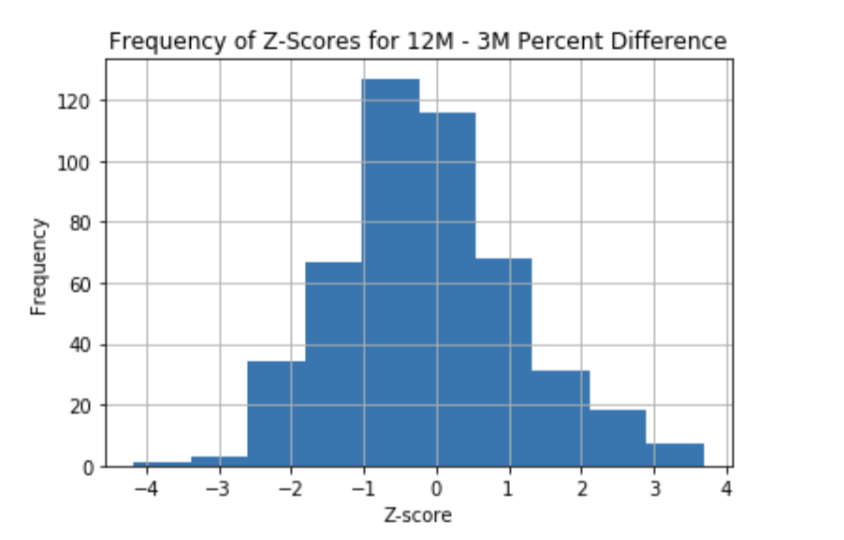

In [304]:
Image("image3.jpg", width = 600, height = 300)

# Find Returns

In [301]:
bond_changes = BondReturnIndex.pct_change()
df1 = pd.DataFrame(index=bond_changes.index)

countries= ["FRA", "DEU", "CHE", "GBR"]
for country in countries:
    signals = monetary_base_signals(country)
    pnl_a = plot_pnl(signals, "Monetary Base", country)
    df1[country] = np.array(pnl_a["net_for_day"])

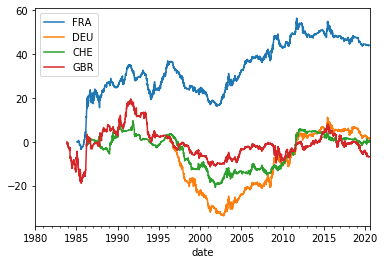

In [302]:
df1.plot()

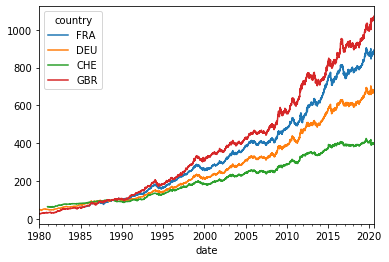

In [309]:
BondReturnIndex[["FRA","DEU","CHE","GBR"]].plot()

# Correlation between Bond Return and Monetary Base 

Goal: show that the returns generated by the monetary base indicator are uncorrelated with the returns of the long-only strategy.

In [127]:
signals = monetary_base_signals("USA")
pnl_values, table = pnl_series(signals, 100, "USA")
mb = table["supply"]
bond_return = table["return"]

mb_change = mg.mean().p

In [313]:
m2 = dl.pull("M2/inUSD")["FRA"]

Correlation Coefficient: -0.13598836793790567


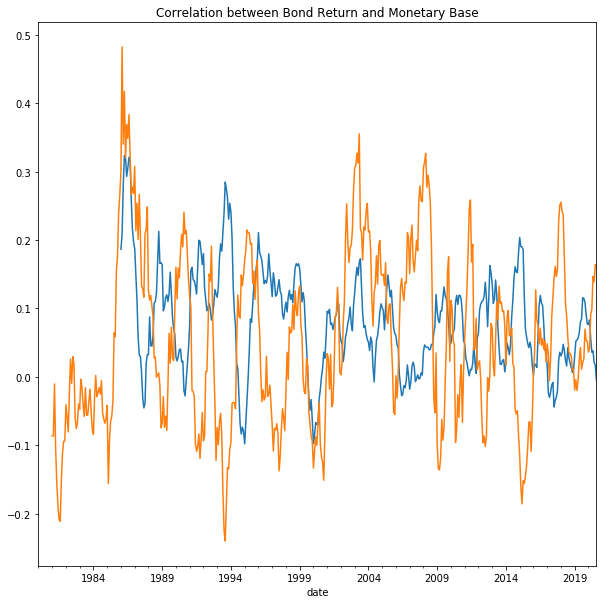

In [315]:
BRI_change = BondReturnIndex.resample("M").mean().pct_change(12)
mb_change = m2.pct_change(12)
fig, ax = plt.subplots(figsize=(10,10))
BRI_change["FRA"].plot()
mb_change.plot()
plt.title("Correlation between Bond Return and Monetary Base")
print("Correlation Coefficient:", mb_change.corr(BRI_change["FRA"]))

Correlation Coefficient: -0.04728227316073595


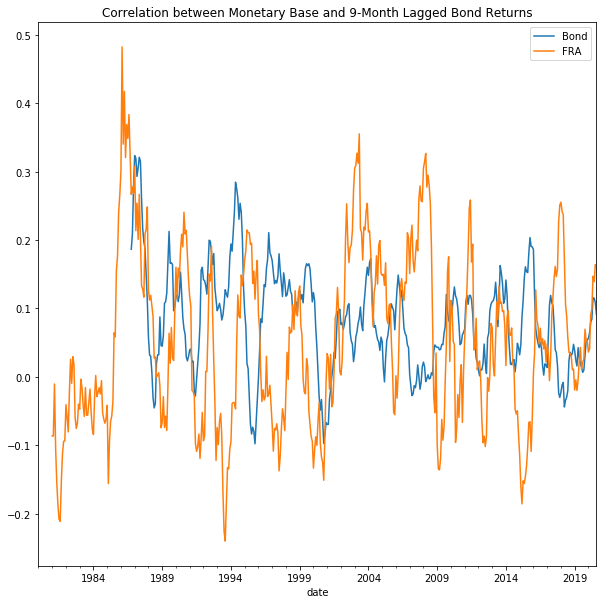

In [316]:
#shifting it by about 9 months, GREATLY reducese the magnitude of the covariance, 
#which makes sense, since money supply is a relatively slow indicator

BRI_change = BondReturnIndex.resample("M").mean().pct_change(12).shift(9)
mb_change = m2.pct_change(12)
fig, ax = plt.subplots(figsize=(10,10))
BRI_change["FRA"].plot(label = "Bond")
mb_change.plot()
plt.title("Correlation between Monetary Base and 9-Month Lagged Bond Returns")
plt.legend()
print("Correlation Coefficient:", mb_change.corr(BRI_change["FRA"]))

# Create a global bond portfolio: 2 country case

Goal: Create a portfolio that is neutral to broad based changes in interest rates. 

Idea: To compare country A with country B, normalize the difference in Z’s for country A and B across time. From there, one can know at a point in time, how meaningful the difference between both countries is.

In [335]:
#neutral to global IR changes
def cross_country(countryA, countryB):
    m2 = dl.pull("M2/inUSD")[countryA]
    m2 = m2.to_frame("supply_A")    
    m2["supply_B"] = dl.pull("M2/inUSD")[countryB]

    m2["year-month"] = m2.index.to_series().astype(str)
    m2["rolling_m3_A"] = m2["supply_A"].rolling(3).mean()
    m2["rolling_m12_A"] = m2["supply_A"].rolling(12).mean()
    m2["m12-m3_A"] = m2["rolling_m12_A"] - m2["rolling_m3_A"]
    
    m2["rolling_m3_B"] = m2["supply_B"].rolling(3).mean()
    m2["rolling_m12_B"] = m2["supply_B"].rolling(12).mean()
    m2["m12-m3_B"] = m2["rolling_m12_B"] - m2["rolling_m3_B"]
    
    m2["standardized"] = 0
    m2["signal_strength"] = 0
    m2["normalized"] = 0


    count = 0
    for i in ["A", "B"]:
        for (index_label, row_series) in m2.iterrows():
            label = str(index_label)
            m2.at[label, "standardized_sd"] = m2["m12-m3_"+i][:count].std()
            m2.at[label, "standardized_mean"] = m2["m12-m3_"+i][:count].mean()
            z_score = (m2.at[label, "m12-m3_"+i]-m2.at[label, "standardized_mean"])/m2.at[label, "standardized_sd"]

            m2.at[label, "signal_strength_"+i] = z_score
            m2.at[label, "normalized"+i] = (norm.cdf(z_score)-.5)*2
            count += 1
    
    #make sure to account for lag
    m2["difference_in_Z"] = m2["signal_strength_A"] - m2["signal_strength_B"]
      
    for (index_label, row_series) in m2.iterrows():
        label = str(index_label)
        m2.at[label, "standardized_sd"] = m2["difference_in_Z"][:count].std()
        m2.at[label, "standardized_mean"] = m2["difference_in_Z"][:count].mean()
        z_score = (m2.at[label, "difference_in_Z"]-m2.at[label, "standardized_mean"])/m2.at[label, "standardized_sd"]

        m2.at[label, "signal_strength_diff"] = z_score
        m2.at[label, "normalized_diff"] = (norm.cdf(z_score)-.5)*2
        count += 1
    return m2  

In [238]:
def pnl(dataset, country1, country2):
    BondReturnIndex = dl.pull('BondRetIdx/LocalFX').resample("M").mean()
    BondReturnIndex["change_1"] = np.exp(np.log(BondReturnIndex[country1]).diff(1))
    BondReturnIndex["change_2"] = np.exp(np.log(BondReturnIndex[country2]).diff(1))
    
    BondReturnIndex["pnl_1"] = dataset["normalized_diff"] * (BondReturnIndex["change_1"] -1) * 100
    BondReturnIndex["pnl_2"] = dataset["weight_usa"] * (BondReturnIndex["change_2"] -1)*100
    
    BondReturnIndex["net"] = -1*(BondReturnIndex["pnl_1"] + BondReturnIndex["pnl_2"])
    
    return BondReturnIndex["net"].cumsum()

In [376]:
norm_diff = cross_country("JPN","USA")
norm_diff["weight_usa"] = (1 - norm_diff["normalized_diff"])*(-1)
BondReturnIndex["USA"] = BondReturnIndex["USA"] - BondReturnIndex["USA"][12]
BondReturnIndex["JPN"] = BondReturnIndex["JPN"] - BondReturnIndex["JPN"][1100]

Text(0.5, 1.0, 'USA and JPN Hedged Returns, Neutral to Shift in Global Rates')

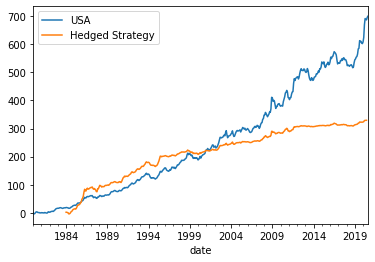

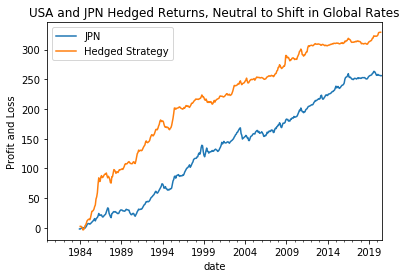

In [377]:
usa = BondReturnIndex["USA"].resample("M").mean().to_frame()
jpn = BondReturnIndex["JPN"].resample("M").mean().to_frame()
usa["Hedged Strategy"] = np.array(pnl(norm_diff, "JPN", "USA"))
jpn["Hedged Strategy"] = np.array(pnl(norm_diff, "JPN", "USA"))
#pnl(norm_diff, "JPN", "USA").plot(figsize = (12,12))
usa.plot()
jpn.plot()
plt.ylabel("Profit and Loss")
plt.title("USA and JPN Hedged Returns, Neutral to Shift in Global Rates")

### Is it global neutral?

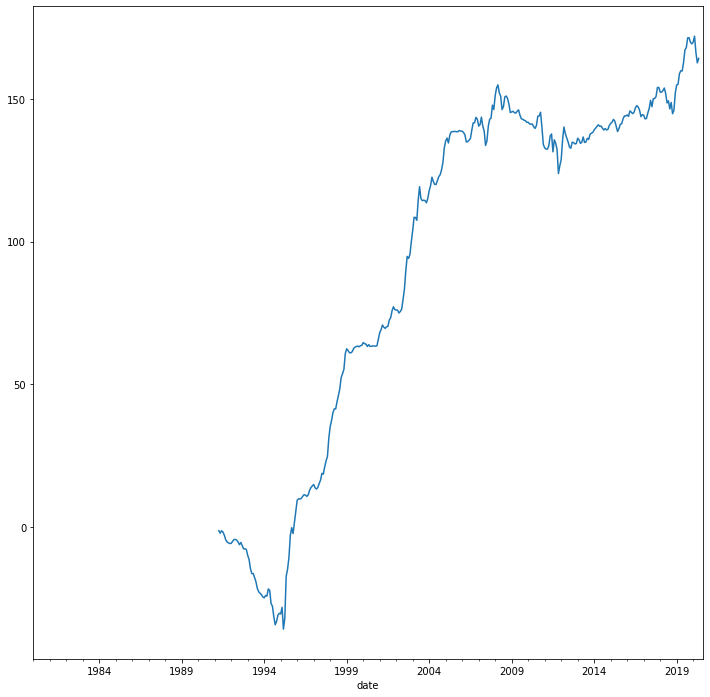

In [245]:
norm_diff = cross_country("FRA","ITA")
norm_diff["weight_usa"] = (1 - norm_diff["normalized_diff"])*(-1)
pnl(norm_diff, "FRA", "ITA").plot(figsize = (12,12))
#norm_diff["normalized_diff"].plot()

### Sharpe ratio